In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import json

In [70]:
dfItaly = pd.read_csv('Country COVID-19 Growth - Italy Correlation.csv',parse_dates=[0])
dfItaly.columns = ['date','cases_total', 'deaths_total', 'cases_active']
dfItaly = dfItaly.set_index('date')

dfItaly['cases_total_log'] = np.log(dfItaly['cases_total'])
dfItaly['deaths_total_log'] = np.log(dfItaly['deaths_total'])
dfItaly['cases_active_log'] = np.log(dfItaly['cases_active'])

dfItaly.head(5)

,cases_total,deaths_total,cases_active,cases_total_log,deaths_total_log,cases_active_log
date,,,,,,
2020-02-22,79,2,75,4.369448,0.693147,4.317488
2020-02-23,157,3,152,5.056246,1.098612,5.023881
2020-02-24,229,7,221,5.433722,1.945910,5.398163
2020-02-25,323,11,310,5.777652,2.397895,5.736572
2020-02-26,470,12,455,6.152733,2.484907,6.120297


In [94]:
title = 'Italy'
shiftSearch = 45

shiftHeadings = []
shiftHeadings = shiftHeadings + ['CaseTotal_autocorr']
shiftHeadings = shiftHeadings + ['CaseTotal_autocorr_log']
shiftHeadings = shiftHeadings + ['CaseActive_autocorr']
shiftHeadings = shiftHeadings + ['CaseActive_autocorr_log']
shiftHeadings = shiftHeadings + ['CaseTotal_Deaths']
shiftHeadings = shiftHeadings + ['CaseTotal_Deaths_log']
shiftHeadings = shiftHeadings + ['CaseActive_Deaths']
shiftHeadings = shiftHeadings + ['CaseActive_Deaths_log']

dfShiftCor = pd.DataFrame(columns = shiftHeadings)
dfShiftCor.index.names = ['Date_Shift']

for i in range(shiftSearch):
    # Auto-correlation of cases (Active and Total) and (Raw and Log)
    caseAutocorr = dfItaly['cases_total'].autocorr(lag=i)
    dfShiftCor.at[i,'CaseTotal_autocorr'] = caseAutocorr
    caseAutocorr = dfItaly['cases_active'].autocorr(lag=i)
    dfShiftCor.at[i,'CaseActive_autocorr'] = caseAutocorr
    caseAutocorr = dfItaly['cases_total_log'].autocorr(lag=i)
    dfShiftCor.at[i,'CaseTotal_autocorr_log'] = caseAutocorr
    caseAutocorr = dfItaly['cases_active_log'].autocorr(lag=i)
    dfShiftCor.at[i,'CaseActive_autocorr_log'] = caseAutocorr

    # Create temp dataframe for shifted date of deaths
    dfTemp = pd.DataFrame(data = dfItaly, columns = ['deaths_total', 'deaths_total_log'])
    dfTemp.columns = ['deathShift_' + str(i), 'deathShiftlog_' + str(i)]
    dfTemp['date_shift'] = dfTemp.index + pd.Timedelta(days=-i)
    dfTemp = dfTemp.set_index('date_shift')
    dfTemp.index.names = ['date']
    dfItaly['deathShift_' + str(i)] = dfTemp['deathShift_' + str(i)]
    dfItaly['deathShiftlog_' + str(i)] = dfTemp['deathShiftlog_' + str(i)]
    
# Correlate cases to deaths    
for (columnName, columnData) in dfItaly.iteritems():
    if 'deathShift_' in columnName:
        i = int(columnName[11:])
        corDeath = dfItaly[['cases_active',columnName]].corr().iloc[0::2,-1].mean()
        dfShiftCor.at[i,'CaseActive_Deaths'] = corDeath
#         print(str(i) + ' ' + str(corDeath))
        corDeath = dfItaly[['cases_total',columnName]].corr().iloc[0::2,-1].mean()
        dfShiftCor.at[i,'CaseTotal_Deaths'] = corDeath
    if 'deathShiftlog_' in columnName:
        i = int(columnName[14:])
        corDeath = dfItaly[['cases_active_log',columnName]].corr().iloc[0::2,-1].mean()
        dfShiftCor.at[i,'CaseActive_Deaths_log'] = corDeath
        corDeath = dfItaly[['cases_total_log',columnName]].corr().iloc[0::2,-1].mean()
        dfShiftCor.at[i,'CaseTotal_Deaths_log'] = corDeath

dfShiftCor.head(5)

,CaseTotal_autocorr,CaseTotal_autocorr_log,CaseActive_autocorr,CaseActive_autocorr_log,CaseTotal_Deaths,CaseTotal_Deaths_log,CaseActive_Deaths,CaseActive_Deaths_log
Date_Shift,,,,,,,,
0,1,1,1,1,0.994674,0.998395,0.982958,0.997652
1,0.999609,0.999729,0.999392,0.999602,0.997054,0.998323,0.988088,0.997739
2,0.998477,0.999639,0.997707,0.999445,0.998721,0.997708,0.992214,0.997144
3,0.996651,0.999545,0.995008,0.999188,0.999661,0.997793,0.995418,0.997398
4,0.994117,0.999354,0.991273,0.998869,0.99987,0.998476,0.997766,0.998344


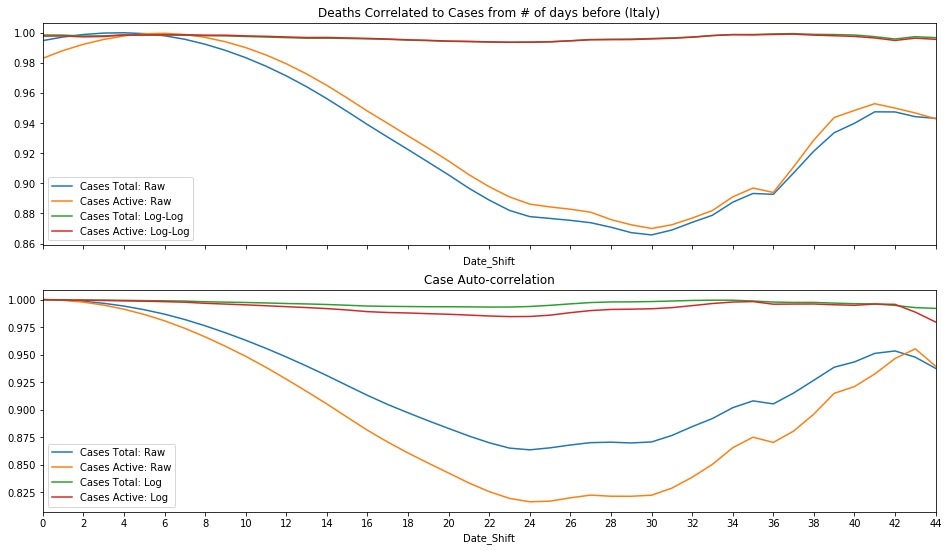

In [95]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,9))
dfShiftCor['CaseTotal_Deaths'].plot(ax=ax1, label = 'Cases Total: Raw')
dfShiftCor['CaseActive_Deaths'].plot(ax=ax1, label = 'Cases Active: Raw')
dfShiftCor['CaseTotal_Deaths_log'].plot(ax=ax1, label = 'Cases Total: Log-Log')
dfShiftCor['CaseActive_Deaths_log'].plot(ax=ax1, label = 'Cases Active: Log-Log')

dfShiftCor['CaseTotal_autocorr'].plot(ax=ax2, label = 'Cases Total: Raw')
dfShiftCor['CaseActive_autocorr'].plot(ax=ax2, label = 'Cases Active: Raw')
dfShiftCor['CaseTotal_autocorr_log'].plot(ax=ax2, label = 'Cases Total: Log')
dfShiftCor['CaseActive_autocorr_log'].plot(ax=ax2, label = 'Cases Active: Log')

ax1.set_title('Deaths Correlated to Cases from # of days before (Italy)')
ax1.set_xticks(range(0,shiftSearch,2))
ax1.set_xticklabels([])
ax1.legend()

ax2.set_title('Case Auto-correlation')
ax2.set_xticks(range(0,shiftSearch,2))
ax2.set_xticklabels(range(0,shiftSearch,2))
ax2.legend()

plt.savefig('figs/Deaths delayed from cases - Italy')
# plt.close(fig)